# Gradient Symbolic Computation

see `TPR_example.ipynb` for details about the TP representation and one possible empirical phenomenon, that can be handled with GSC.

In [1]:
# Imports
from src.classes.Grammar import Grammar
from src.gsc.gsc_network import Net
import pandas as pd
import torch
# Set seed for reproducibility
torch.manual_seed(123)

## Grammar and Harmonic Constraints

In [2]:
# Fillers and Roles
fillers = ["bh", "b", "u", "d", "dh"]
roles = ["s1", "s2", "s3"]

similarities = torch.tensor([[1, 0.75, 0, 0, 0, 0],
                             [0.75, 1, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 1, 0.75, 0],
                             [0, 0, 0, 0.75, 1, 0],
                             [0, 0, 0, 0, 0, 1]])

# Build Grammar
# G = Grammar(fillers, roles, emtpyFiller="#")
G = Grammar(fillers, roles, emtpyFiller="_", fillerSimilarities=similarities)

Buil Filler Matrix
Representations built after 392 attempts

Build role Matrix
Representations built after 177 attempts



__Single Constituents Harmony__

The following code sets the harmony values for single bindings. 
For instance the constraint `("b/s1", 2)` means that the segment "b" in first position ("s1") improves the general harmony by 2. 

There will be *Harmony crosstalk* if the vector representing those bindings are not independent (dot product == 0). Let's suppose that the vector representing "b/s1" has a non-null dotproduct with the vector representing "bh/s1". Then "bh/s1" will also improve its harmony by a factor $H_{b/s1} \times (b/s1 \cdot bh/s1)$


In [3]:
# Single Harmony constraints
cons = [("b/s1", 2), ("bh/s1", 2), ("u/s2", 5), ("d/s3", 2), ("dh/s3", 5)]
G.update_Hc(cons)

__Pairwise Harmony__

These constraints provide a way to declare Harmonic Constraints in the GSC. 
Ex.:

`("u/s2" "d/s3", -3)` means that the co-occurence of "u" in the secondo position and "d" in the third position makes the total Harmony decrease by -3 points. This  (indirectly) implement the preference for "dh" in "s3".


In [4]:
# Pairwise Harmony
# Matrix dim: (nF, nR, nF, nR)
cons = [("u/s2", "d/s3", -3),
        ("b/s1", "dh/s3", 5)]
G.update_Hcc(cons)

### Single binding Harmonies:

In [5]:
harmonies = G.Hc.numpy()
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3
bh,2.0,0.0,0.0
b,2.0,0.0,0.0
u,0.0,5.0,0.0
d,0.0,0.0,2.0
dh,0.0,0.0,5.0
_,0.0,0.0,0.0


In [6]:
import seaborn as sns

<AxesSubplot:>

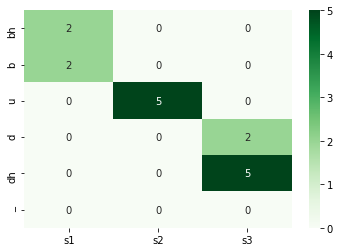

In [7]:
sns.heatmap(harmonies, annot=True, cmap="Greens")

### Pairwise Harmonies:

In [8]:
# Harmonies for the binding : u/s2
harmonies = G.Hcc.numpy()[:,:,2,1]
harmonies = pd.DataFrame(harmonies, columns=roles, index=fillers)
harmonies

,s1,s2,s3
bh,0.0,0.0,0.0
b,0.0,0.0,0.0
u,0.0,0.0,0.0
d,0.0,0.0,-3.0
dh,0.0,0.0,3.0
_,0.0,0.0,0.0


<AxesSubplot:>

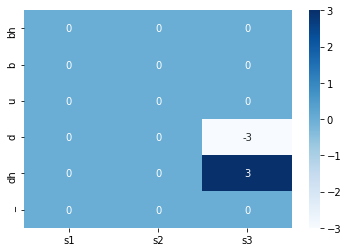

In [9]:
sns.heatmap(harmonies, annot=True, cmap="Blues")

The preceding matrix is the matrix for "u" in second position, the binding "u/s2". We implemented the harmony constraint ("u/s2", "d/s3", -3) and ("u/s2", "dh/s3", 3) and this is what the heatmap is visualizing.

## GSC Net

In [10]:
# Custom settings (these substitute the hard-coded settings)

# ---------------------------------------
#           GSC NET
# ---------------------------------------

custom_settings = {"epochs": 5,
                   "tgtStd": 0.00125,
                   "emaFactor": 0.05,
                   "emaSpeedTol": 0.002,
                   "dt": 1e-5,
                   "T_decay_rate": 0.05,
                   "maxSteps": 50000,
                   "printInterval": 25000}
# Initialize
N = Net(G, custom_settings=custom_settings, extData_path="data/inp_pandas.csv")


Input processed: b-bh-u-dh

Input processed: b-u-dh

Value for Q set to 16.26776109327919
LAMBDA RECOMMENDED: 0.01422198802943719, ACTUAL LAMBDA = 0.011387


If you want to change to the recommended Lambda value press 'y', else any other key: y


T RECOMMENDED: 2.3761105810755308e-05, ACTUAL T = -1


If you want to change to the recommended value press 'y', else any other key: y


The external data were provided in form of a simple csv file and were imported in the GSCNet using `pandas`:

In [11]:
# EXTERNAL INPUTS 

# Read dataframe
inputs = pd.read_csv("data/inp_pandas.csv", sep=",")
inputNames = []
nStimuli = len(inputs['id'].unique())

# Initialize stimuli tensor
stimuli = torch.zeros((nStimuli, len(fillers) + 1, len(roles)))

# Loop over the single inputs as whole
for idx, i in enumerate(inputs['id'].unique()):
    inp_string = ""
    stimulus = inputs[inputs.id == i].to_numpy()[:, 1:]

    # Loop over the fillers in a given input
    for filler in stimulus:
        fidx = N.filler2index[filler[0]]
        inp_string += filler[0] + "-"
        for roledix in range(N.grammar.bind.nR):
            stimuli[idx, fidx, roledix] = filler[roledix+1]
    print(f"Input processed: {inp_string[:-1]}\n")
    # Store the names for later plotting
    inputNames.append(inp_string[:-1])

Input processed: b-bh-u-dh

Input processed: b-u-dh



The first imput is a gradient blend for the root *{b, bh}ud*:

     s1   s2   s3
bh  0.7  0.0  0.0
b   0.8  0.0  0.0
u   0.0  1.0  0.0
d   0.0  0.0  0.0
dh  0.0  0.0  1.0
_   0.0  0.0  0.0


<AxesSubplot:>

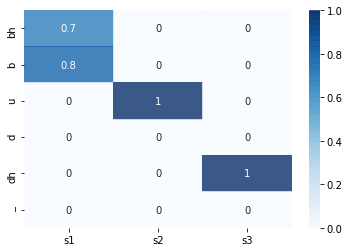

In [12]:
b_bh_ud = N.stimuli[0,:,:].numpy()
b_bh_ud = pd.DataFrame(b_bh_ud, columns=roles, index=fillers)
print(b_bh_ud)
sns.heatmap(b_bh_ud, alpha=.8, cmap="Blues", annot=True)

## Training (Optimization + Quantization)

In [13]:
# Run
p = N()

Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.01422198802943719	 Harmony: 40.88941192626953

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.011330906619084124	 Harmony: 33.65285873413086

epoch : 1
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.674412  0.592966  0.696598
b   0.685469  0.468440  0.503296
u   0.390630  0.872105  0.555379
d   0.380568  0.674823  1.174426
dh  0.383475  0.565681  1.140686
_   0.376701  0.739082  0.915923
Nearest TP: b-u-d
Distance between prediction and nearest TP: 2.82


Stimulus routine::  50%|█████     | 1/2 [00:27<00:27, 27.69s/it]


Last best Harmony: 13.849176760721917


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.009031611291664871	 Harmony: 40.293277740478516

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.007203114105857327	 Harmony: 32.917152404785156

epoch : 1
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.644966  0.599893  0.700152
b   0.665729  0.465864  0.503095
u   0.391198  0.874430  0.557566
d   0.379991  0.679540  1.181536
dh  0.389633  0.565594  1.144111
_   0.376416  0.740164  0.916802
Nearest TP: b-u-d
Dist


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 12.103758067113517


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.005748898731475141	 Harmony: 40.88941192626953

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.004592444974575413	 Harmony: 33.482662200927734

epoch : 2
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.678598  0.597817  0.700597
b   0.692451  0.467507  0.504039
u   0.392646  0.877953  0.557111
d   0.384959  0.680287  1.184130
dh  0.386105  0.564341  1.142733
_   0.379320  0.742325  0.917390
Nearest TP: b-u-d
Distan


Stimulus routine::  50%|█████     | 1/2 [00:27<00:27, 27.07s/it]


Last best Harmony: 12.21027677880771


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.003672709988872866	 Harmony: 40.293277740478516

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.002941297710949786	 Harmony: 32.95176696777344

epoch : 2
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.648164  0.601176  0.702251
b   0.671560  0.466066  0.501202
u   0.392569  0.876576  0.557697
d   0.384001  0.678178  1.182096
dh  0.389157  0.563079  1.141854
_   0.381189  0.739676  0.913794
Nearest TP: b-u-d
Distan


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 11.585439647940149


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0023596009012289707	 Harmony: 40.88941192626953

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.001897010921210363	 Harmony: 33.65906524658203

epoch : 3
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.682861  0.595436  0.697913
b   0.690322  0.467888  0.503297
u   0.391647  0.877192  0.557152
d   0.386153  0.674282  1.180437
dh  0.390753  0.562785  1.141206
_   0.382218  0.736778  0.910500
Nearest TP: b-u-d
Distan


Stimulus routine::  50%|█████     | 1/2 [00:27<00:27, 27.22s/it]


Last best Harmony: 12.406705192213181


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.001529110184911908	 Harmony: 40.293277740478516

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0012365399122043698	 Harmony: 33.18024444580078

epoch : 3
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.647910  0.593161  0.694670
b   0.674761  0.467756  0.501989
u   0.395147  0.878927  0.556457
d   0.388513  0.675698  1.177288
dh  0.388650  0.558086  1.138600
_   0.380931  0.734401  0.905316
Nearest TP: b-u-d
Dist


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 12.242630984955483


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0010038569242507192	 Harmony: 40.88941192626953

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0008188175412776387	 Harmony: 33.92166519165039

epoch : 4
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.683387  0.594868  0.692528
b   0.693477  0.464436  0.498980
u   0.394664  0.877143  0.554468
d   0.383613  0.669332  1.174214
dh  0.392553  0.560079  1.134590
_   0.382336  0.729658  0.900586
Nearest TP: b-u-d
Dista


Stimulus routine::  50%|█████     | 1/2 [00:27<00:27, 27.11s/it]


Last best Harmony: 13.32270297068139


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0006716545499018536	 Harmony: 40.293277740478516

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0005546242961642108	 Harmony: 33.4813117980957

epoch : 4
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.650052  0.593477  0.690291
b   0.673665  0.462452  0.496451
u   0.395461  0.875285  0.552227
d   0.386553  0.669216  1.169389
dh  0.390699  0.556513  1.132771
_   0.380626  0.725188  0.894041
Nearest TP: b-u-d
Dista


Stimulus routine::   0%|          | 0/2 [00:00<?, ?it/s]


Last best Harmony: 13.311942711489124


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.00046154939532536707	 Harmony: 40.88941192626953

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.695062  0.400000  0.400000
b   0.696599  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.955837828969228

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0003875322857250255	 Harmony: 34.263084411621094

epoch : 5
stimNum : 1

Conceptual Matrix:
          s1        s2        s3
bh  0.682826  0.589979  0.685709
b   0.694328  0.462829  0.496684
u   0.394750  0.873984  0.550387
d   0.385113  0.663229  1.162585
dh  0.392357  0.555464  1.131452
_   0.382884  0.721990  0.887594
Nearest TP: b-u-d
Dis


Stimulus routine::  50%|█████     | 1/2 [00:27<00:27, 27.84s/it]


Last best Harmony: 14.584918418373789


--------------------------------------------------------------------------------

STEP : 0	 Lambda : 0.0003286660104123713	 Harmony: 40.293277740478516

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.661253  0.400000  0.400000
b   0.676621  0.400000  0.400000
u   0.400000  0.774956  0.400000
d   0.400000  0.400000  0.763836
dh  0.400000  0.400000  0.896763
_   0.400000  0.400000  0.400000
Nearest TP: b-u-dh
Distance between prediction and nearest TP: 1.9461598997996337

--------------------------------------------------------------------------------

STEP : 25000	 Lambda : 0.0002818530510397406	 Harmony: 33.80680465698242

epoch : 5
stimNum : 2

Conceptual Matrix:
          s1        s2        s3
bh  0.649628  0.585200  0.684202
b   0.674053  0.462900  0.495663
u   0.393953  0.872775  0.547255
d   0.386485  0.664067  1.159633
dh  0.391758  0.549915  1.127097
_   0.384256  0.718344  0.882293
Nearest TP: b-u-d
Dis


Epoch routine:: 100%|██████████| 5/5 [04:34<00:00, 54.92s/it]


Last best Harmony: 14.537994779435891



# Visualization

In [48]:
from src.gsc.plotting import Plot
import matplotlib.pyplot as plt

In [49]:
fp = "data/full_traces.pt"
nr = len(roles)
nf = len(fillers) +1 
statesDict = G.bind.states
inputNames = N.inputNames


p = Plot(fp_traces="data/full_traces.pt", nf=nf,nr=nr, inputNames=inputNames, statesDict=statesDict)

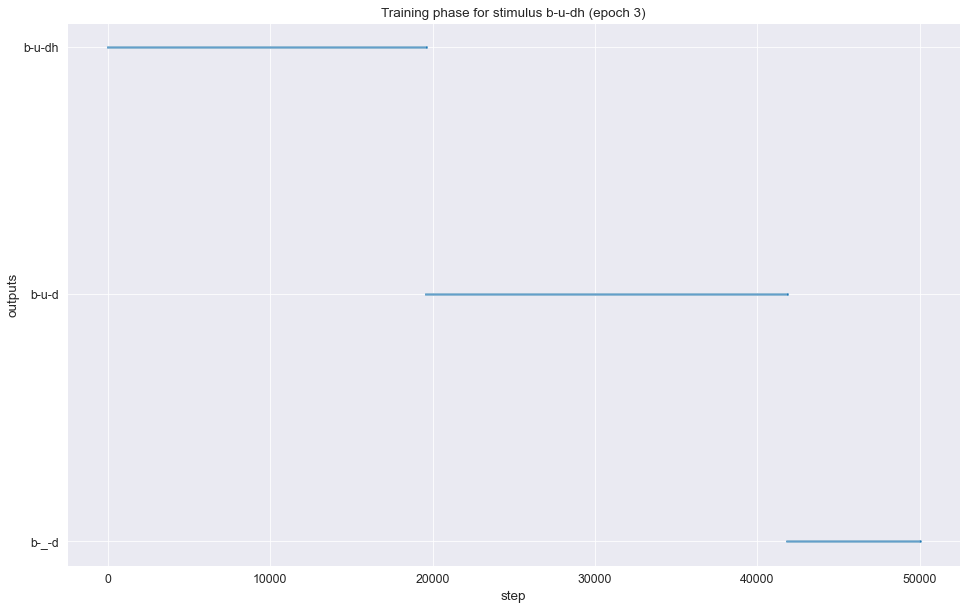

In [50]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(1, 3)

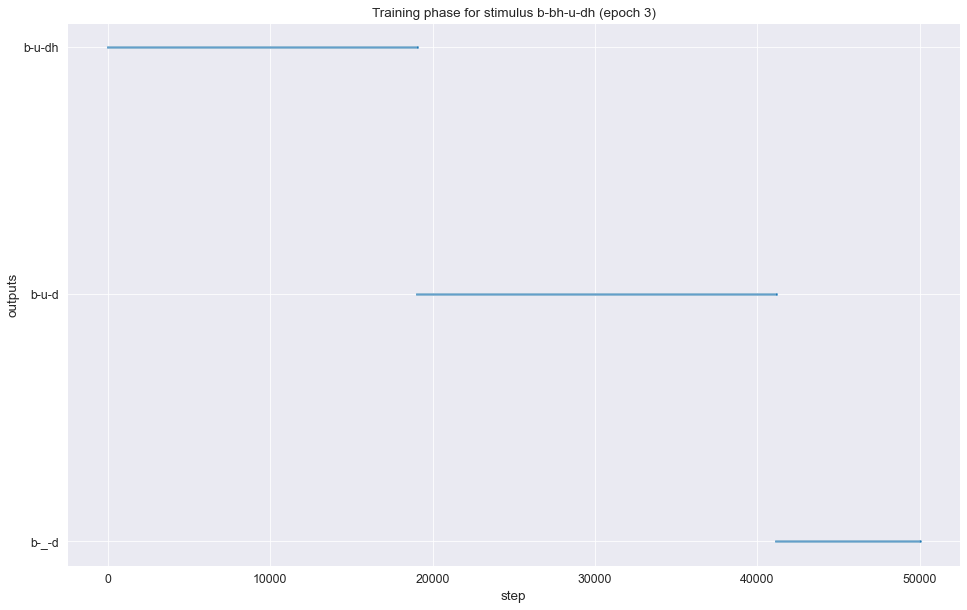

In [44]:
plt.figure(figsize=(16,10))
df = p.plot_epoch(0, 3)

In [ ]:
plt.figure(figsize=(16,10))
df = p.plot_harmonyProb(1, 4, lm=False)